# Packages

In [24]:
!pip install pandas matplotlib networkx seaborn
!pip install pyvis --quiet  # For interactive network graphs
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install langdetect
!pip install validators

# Qixian: This cell takes around 20 seconds and may need to restart kernel

import pandas as pd
import spacy
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 4.2 MB/s eta 0:00:03
     ---- ----------------------------------- 1.3/12.8 MB 3.7 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 3.4 MB/s eta 0:00:04
     ------- -------------------------------- 2.4/12.8 MB 2.8 MB/s eta 0:00:04
     --------- ------------------------------ 2.9/12.8 MB 2.8 MB/s eta 0:00:04
     --------- ------------------------------ 3.1/12.8 MB 2.6 MB/s eta 0:00:04
     ----------- ---------------------------- 3.7/12.8 MB 2.6 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.8 MB 2.6 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.5 MB/s eta 0:00:04
     ----------------- ---------------------- 5.5/12.8 MB 2.6 MB/s eta 0:00:03
     ------------------ --------------------- 6.0/12.8 MB 2.6 MB/s eta 0:00:03
     --------------------- ------------------ 6.8/12.8 MB 2

# Dataset Import

In [25]:
import pandas as pd

# Provide the path to your Excel file
file_path = "news_excerpts_parsed.xlsx"

# Load the dataset
df_original = pd.read_excel(file_path)
df = df_original.copy()

# View the first few rows
print(df.head())
print(df.info())


                                                Link  \
0  https://edition.cnn.com/2023/09/29/business/st...   
1  https://www.channelnewsasia.com/singapore/su-w...   
2  https://edition.cnn.com/2023/05/22/tech/meta-f...   
3  https://www.channelnewsasia.com/singapore/bill...   
4  https://edition.cnn.com/2024/03/05/politics/li...   

                                                Text  
0  Starbucks violated federal labor law when it i...  
1  The first suspect to plead guilty in Singapore...  
2  Meta has been fined a record-breaking €1.2 bil...  
3  SINGAPORE: A 45-year-old man linked to Singapo...  
4  The Department of Education imposed a record $...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Link    1509 non-null   object
 1   Text    1509 non-null   object
dtypes: object(2)
memory usage: 23.7+ KB
None


# Validation

In [22]:
def validate_data(dataframe):
    original_rows = len(dataframe)

    # Check for missing values
    dataframe = dataframe.dropna(subset=['Text'])
    rows_removed_missing = original_rows - len(dataframe)

    # Check for empty strings or whitespaces
    dataframe['content_length'] = dataframe['Text'].apply(lambda x: len(str(x).strip()))
    dataframe = dataframe[dataframe['content_length'] > 0]
    rows_removed_empty = original_rows - len(dataframe) - rows_removed_missing

    # Remove duplicates
    original_rows = len(dataframe)
    dataframe = dataframe.drop_duplicates(subset=['Text'], keep='first')
    rows_removed_duplicates = original_rows - len(dataframe)

    # Check for invalid lengths
    min_length, max_length = 50, 10000
    # Use 'content_length' instead of 'Text_length' for filtering
    dataframe = dataframe[(dataframe['content_length'] >= min_length) & (dataframe['content_length'] <= max_length)]
    rows_removed_length = original_rows - len(dataframe)

    # Final count
    final_rows = len(dataframe)
    rows_removed_total = original_rows - final_rows

    # Summary
    print("Data Validation Summary:")
    print(f"Total Rows Initially: {original_rows}")
    print(f"Rows Removed (Missing Content): {rows_removed_missing}")
    print(f"Rows Removed (Empty Content): {rows_removed_empty}")
    print(f"Rows Removed (Duplicates): {rows_removed_duplicates}")
    print(f"Rows Removed (Invalid Length): {rows_removed_length}")
    print(f"Final Row Count: {final_rows}")
    print(f"Total Rows Removed: {rows_removed_total}")

    return dataframe

df = validate_data(df)

Data Validation Summary:
Total Rows Initially: 1509
Rows Removed (Missing Content): 0
Rows Removed (Empty Content): 0
Rows Removed (Duplicates): 0
Rows Removed (Invalid Length): 0
Final Row Count: 1509
Total Rows Removed: 0


In [23]:
import validators
import requests
from tqdm import tqdm
from langdetect import detect

def additional_checks_with_progress(dataframe):
    """
    Perform additional checks for non-English content and validate URLs.
    Perform accessibility checks only on links with invalid format and remove inaccessible ones.
    """
    original_rows = len(dataframe)  # Initial row count

    # Initialize tqdm progress bar
    tqdm.pandas(desc="Processing rows")

    # 1. Detect Non-English Content
    print("Checking for non-English content...")
    def detect_language_with_progress(text):
        try:
            return detect(text)
        except:
            return "error"

    dataframe['language'] = dataframe['Text'].progress_apply(detect_language_with_progress)
    non_english_rows = dataframe[dataframe['language'] != 'en']  # Identify non-English rows
    dataframe = dataframe[dataframe['language'] == 'en']  # Keep only English rows
    rows_removed_non_english = len(non_english_rows)

    # 2. Validate URLs in the 'Link' column
    print("Validating URL format...")
    def is_format_valid(url):
        """
        Validates the URL format using validators.
        Returns True if the format is valid, False otherwise.
        """
        try:
            return validators.url(url.strip()) is True  # Strip whitespace before validation
        except:
            return False

    dataframe['valid_format'] = dataframe['Link'].progress_apply(is_format_valid)

    # Log invalid format links
    invalid_format_links = dataframe[~dataframe['valid_format']]  # Links with invalid format
    if not invalid_format_links.empty:
        print("\nLinks with Invalid Format:")
        print(invalid_format_links['Link'].tolist())

    # 3. Perform Accessibility Check on Invalid Format Links
    print("Checking accessibility for invalid format links...")
    def is_accessible(url):
        """
        Checks accessibility of a URL using a GET request with headers.
        Returns True if the URL is accessible, False otherwise.
        """
        try:
            # Normalize the URL by stripping spaces and adding http:// if missing
            url = url.strip()
            if not url.startswith(("http://", "https://")):
                url = "http://" + url

            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }
            response = requests.get(url, headers=headers, timeout=5)
            return response.status_code < 400  # Accessible if status code is OK
        except:
            return False

    # Perform accessibility check only on invalid format links
    invalid_format_links['accessible'] = invalid_format_links['Link'].progress_apply(is_accessible)

    # Log inaccessible links
    inaccessible_links = invalid_format_links[~invalid_format_links['accessible']]
    if not inaccessible_links.empty:
        print("\nInaccessible Links Removed:")
        print(inaccessible_links['Link'].tolist())

    # Remove inaccessible links
    valid_invalid_links = invalid_format_links[invalid_format_links['accessible']]
    dataframe = pd.concat([dataframe[dataframe['valid_format']], valid_invalid_links])

    # Final row count
    final_rows = len(dataframe)
    rows_removed_invalid_links = len(inaccessible_links)
    rows_removed_total = original_rows - final_rows

    # Print the additional validation summary
    print("\nAdditional Validation Summary:")
    print(f"Total Rows Initially: {original_rows}")
    print(f"Rows Removed (Non-English Content): {rows_removed_non_english}")
    print(f"Rows Removed (Invalid Format and Inaccessible Links): {rows_removed_invalid_links}")
    print(f"Final Row Count After Additional Checks: {final_rows}")
    print(f"Total Rows Removed in Additional Checks: {rows_removed_total}")

    # Return the cleaned dataframe
    return dataframe

# Apply the additional checks with progress bar
df = additional_checks_with_progress(df)


Checking for non-English content...


Processing rows: 100%|██████████| 1509/1509 [00:02<00:00, 585.39it/s]


Validating URL format...


Processing rows: 100%|██████████| 1509/1509 [00:00<00:00, 104703.22it/s]



Links with Invalid Format:
['https://www.straitstimes.com/multimedia/graphics/2023/10/asia-extreme-lake-kayangan/index.html?shell', 'https://www.straitstimes.com/multimedia/graphics/2024/03/chinese-investment-philippines/index.html?shell', 'https://www.straitstimes.com/multimedia/graphics/2023/11/illegal-pet-trade-singapore/index.html?shell']
Checking accessibility for invalid format links...


Processing rows: 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


Additional Validation Summary:
Total Rows Initially: 1509
Rows Removed (Non-English Content): 0
Rows Removed (Invalid Format and Inaccessible Links): 0
Final Row Count After Additional Checks: 1509
Total Rows Removed in Additional Checks: 0



C:\Users\Zhao Qixian\AppData\Local\Temp\ipykernel_19460\2165157685.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_format_links['accessible'] = invalid_format_links['Link'].progress_apply(is_accessible)


# Extract Entities and Relationships

In [27]:
from tqdm import tqdm
import spacy

# Initialize SpaCy model and TQDM progress bar
nlp = spacy.load("en_core_web_sm")
tqdm.pandas(desc="Extracting Entities and Relationships")

# Function to extract entities using SpaCy
def extract_entities(text):
    """
    Extract named entities from text using SpaCy.
    Returns a list of (entity, label) tuples.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Function to extract relationships using dependency parsing
def extract_relationships(text):
    """
    Extracts relationships between entities based on dependency parsing.
    Returns a list of (subject, verb, object) tuples.
    """
    doc = nlp(text)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj") and token.head.pos_ == "VERB":
            relationships.append((token.text, token.head.text, token.head.i))
    return relationships

# Apply entity and relationship extraction to the DataFrame
df['entities'] = df['Text'].progress_apply(extract_entities)  # Extract entities
df['relationships'] = df['Text'].progress_apply(extract_relationships)  # Extract relationships

# Add number of entities and relationships to the same DataFrame
df['num_entities'] = df['entities'].apply(len)  # Count the number of entities
df['num_relationships'] = df['relationships'].apply(len)  # Count the number of relationships

# Display the head of the DataFrame with the new columns
print(df[['Text', 'entities', 'num_entities', 'relationships', 'num_relationships']].head())


Extracting Entities and Relationships: 100%|██████████| 1509/1509 [00:19<00:00, 78.22it/s]

                                                Text  \
0  Starbucks violated federal labor law when it i...   
1  The first suspect to plead guilty in Singapore...   
2  Meta has been fined a record-breaking €1.2 bil...   
3  SINGAPORE: A 45-year-old man linked to Singapo...   
4  The Department of Education imposed a record $...   

                                            entities  num_entities  \
0  [(National Labor Relations Board, ORG), (Thurs...             6   
1  [(first, ORDINAL), (Singapore, GPE), (13 month...            17   
2  [(Meta, ORG), (€1.2 billion, MONEY), ($1.3 bil...            19   
3  [(SINGAPORE, GPE), (45-year-old, DATE), (Singa...            14   
4  [(The Department of Education, ORG), (a record...            17   

                                       relationships  num_relationships  
0  [(Starbucks, violated, 1), (law, violated, 1),...                 15  
1  [(Wenqiang, admitted, 39), (proceeds, possessi...                  5  
2  [(billion, fined,

In [29]:
total_entities = df['entities'].apply(len).sum()
total_relationships = df['relationships'].apply(len).sum()

print(f"Total number of entities: {total_entities}")
print(f"Total number of relationships: {total_relationships}")

Total number of entities: 21323
Total number of relationships: 20062


# Frequency Analysis

In [31]:
from collections import Counter

all_entities = [ent[1] for entities in df['entities'] for ent in entities]
entity_counts = Counter(all_entities)
print(entity_counts.most_common(10))  # Top 10 entity types

all_verbs = [rel[1] for relationships in df['relationships'] for rel in relationships]
verb_counts = Counter(all_verbs)
print(verb_counts.most_common(10))  # Top 10 verbs

[('ORG', 4485), ('GPE', 4191), ('DATE', 3784), ('PERSON', 3560), ('CARDINAL', 1714), ('NORP', 1387), ('MONEY', 583), ('ORDINAL', 408), ('LOC', 328), ('FAC', 193)]
[('said', 1352), ('told', 382), ('have', 292), ('has', 267), ('had', 195), ('made', 133), ('took', 132), ('announced', 122), ('’s', 122), ('take', 114)]


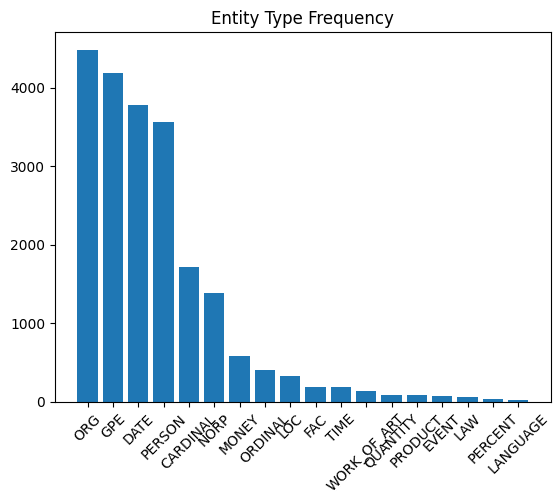

In [37]:
import matplotlib.pyplot as plt

labels, counts = zip(*entity_counts.most_common())
plt.bar(labels, counts)
plt.title("Entity Type Frequency")
plt.xticks(rotation=45)
plt.show()


import random

# Define the number of relationships to sample
sample_size = 500  # Adjust based on your needs
sampled_relationships = random.sample(
    [rel for relationships in df['relationships'] for rel in relationships],
    min(sample_size, sum(df['num_relationships']))
)




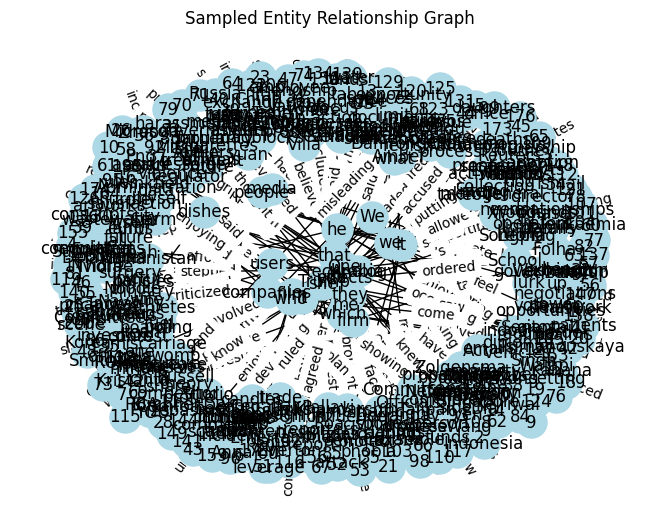

In [38]:
import random

# Define the number of relationships to sample
sample_size = 500  # Adjust based on your needs
sampled_relationships = random.sample(
    [rel for relationships in df['relationships'] for rel in relationships],
    min(sample_size, sum(df['num_relationships']))
)

# Create a smaller graph
G_sampled = nx.DiGraph()
for subj, verb, obj_index in sampled_relationships:
    G_sampled.add_edge(subj, obj_index, label=verb)

# Plot the sampled graph
pos = nx.spring_layout(G_sampled)
nx.draw(G_sampled, pos, with_labels=True, node_size=500, node_color="lightblue")
edge_labels = nx.get_edge_attributes(G_sampled, 'label')
nx.draw_networkx_edge_labels(G_sampled, pos, edge_labels=edge_labels)
plt.title("Sampled Entity Relationship Graph")
plt.show()

# Pending

In [17]:
# Initialize a directed graph
entity_graph = nx.DiGraph()

# Add entities as nodes in the graph
for _, row in df.iterrows():
    for ent, label in row['entities']:
        entity_graph.add_node(ent, label=label)  # Add entity nodes with labels

# Add relationships as edges in the graph
for _, row in df.iterrows():
    for subj, verb, obj_token in row['relationships']:
        obj = obj_token.text  # Get object text
        if subj in entity_graph and obj in entity_graph:
            entity_graph.add_edge(subj, obj, relation=verb)  # Add directed edge with verb as relation


In [12]:
import networkx as nx
from tqdm import tqdm

# Initialize the graph
entity_graph = nx.DiGraph()

# Define a function to extract entities using SpaCy
nlp = spacy.load("en_core_web_sm")
tqdm.pandas(desc="Extracting Entities")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Extract entities from the 'Text' column
df['entities'] = df['Text'].progress_apply(extract_entities)

# Add entities to the graph
for _, row in df.iterrows():
    for ent, label in row['entities']:
        entity_graph.add_node(ent, label=label)


Extracting Entities: 100%|██████████| 1509/1509 [00:19<00:00, 75.96it/s]


In [13]:
def extract_relationships(text):
    doc = nlp(text)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj") and token.head.pos_ == "VERB":
            relationships.append((token.text, token.head.text, token.head))
    return relationships

tqdm.pandas(desc="Extracting Relationships")
df['relationships'] = df['Text'].progress_apply(extract_relationships)

# Add relationships as edges
for _, row in df.iterrows():
    for subj, verb, obj_token in row['relationships']:
        obj = obj_token.text
        if subj in entity_graph and obj in entity_graph:
            entity_graph.add_edge(subj, obj, relation=verb)


Extracting Relationships: 100%|██████████| 1509/1509 [00:18<00:00, 80.07it/s]


In [14]:
from pyvis.network import Network

# Create a PyVis Network
net = Network(notebook=True, directed=True)
net.from_nx(entity_graph)

# Save and display the graph
net.show("entity_relationship_graph.html")


entity_relationship_graph.html


In [11]:
entity_counts = pd.Series([ent for ents in df['entities'] for ent, _ in ents]).value_counts()
print(entity_counts.head(10))


Singapore    409
China        335
two          245
first        239
US           188
one          166
Chinese      141
Thursday     140
Wednesday    126
Russia       124
Name: count, dtype: int64


In [12]:
relationship_counts = pd.Series([rel[1] for rels in df['relationships'] for rel in rels]).value_counts()
print(relationship_counts.head(10))


said         1352
told          382
have          292
has           267
had           195
made          133
took          132
’s            122
announced     122
take          114
Name: count, dtype: int64


In [13]:
df.to_excel("validated_data_with_entities_and_relationships.xlsx", index=False)
